<center><h1>Time series analysis</h1></center>
<center><h2>Laboratorio I</h2></center>

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

## Cargamos los datos

In [4]:
movil=pd.read_csv('datasets/Telefonia_movil.csv', dayfirst=True, thousands='.')
movil.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
17,2017,2,15315167,6293563,21608730,Abr-Jun 2017
18,2017,3,15106275,6308373,21414647,Jul-Sept 2017
19,2017,4,14164552,5380710,19545262,Oct-Dic 2017
20,2018,1,13851254,5958717,19809971,Ene-Mar 2018
21,2018,2,14388755,6290155,20678910,Abr-Jun 2018


In [5]:
movil.index=pd.PeriodIndex(movil['Año'].astype(str) + 'Q' + movil['Trimestre'].astype(str),freq='Q')

movil.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2017Q2,2017,2,15315167,6293563,21608730,Abr-Jun 2017
2017Q3,2017,3,15106275,6308373,21414647,Jul-Sept 2017
2017Q4,2017,4,14164552,5380710,19545262,Oct-Dic 2017
2018Q1,2018,1,13851254,5958717,19809971,Ene-Mar 2018
2018Q2,2018,2,14388755,6290155,20678910,Abr-Jun 2018


## Hacemos una exploración de los datos

In [6]:
movil.describe()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles)
count,22.000000,22.000000,2.200000e+01,2.200000e+01,2.200000e+01
mean,2015.272727,2.409091,1.209691e+07,6.604273e+06,1.870118e+07
std,1.638287,1.140555,2.077349e+06,5.251805e+05,1.990543e+06
min,2013.000000,1.000000,8.785943e+06,5.380710e+06,1.536806e+07
25%,2014.000000,1.250000,1.044198e+07,6.291007e+06,1.735731e+07
50%,2015.000000,2.000000,1.164553e+07,6.580968e+06,1.883452e+07
75%,2016.750000,3.000000,1.408623e+07,7.100940e+06,1.974379e+07
max,2018.000000,4.000000,1.596076e+07,7.335154e+06,2.289966e+07


### Dibujamos la serie de tiempo, eligiendo la columna Total de minutos salientes

In [7]:
y=movil['Total de minutos salientes (miles)']

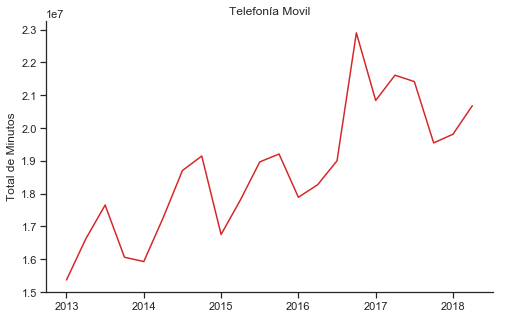

In [8]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Total de Minutos')
ax.set_title('Telefonía Movil')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [9]:
y.describe().round(2)

count          22.00
mean     18701180.05
std       1990542.72
min      15368060.00
25%      17357310.00
50%      18834516.00
75%      19743793.75
max      22899656.00
Name: Total de minutos salientes (miles), dtype: float64

In [10]:
y=movil['Total de minutos salientes (miles)']

## Random walk

Aplicamos Random walk, para predecir 4 trimestres 

In [11]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q3    20678910
2018Q4    20678910
2019Q1    20678910
2019Q2    20678910
Freq: Q-DEC, dtype: int64

Estimamos la desviación estandar de los erroes

In [12]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1464911.401

Las predicciones de los intervalos son:

In [13]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q3,1.780774e+07,2.355008e+07
2018Q4,1.661846e+07,2.473936e+07
2019Q1,1.570589e+07,2.565193e+07
2019Q2,1.493656e+07,2.642126e+07


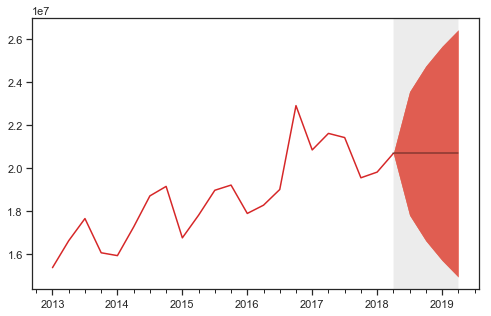

In [14]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2010':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

Verificamos la versión del paquete statsmodels

In [15]:
import statsmodels
statsmodels.__version__

'0.9.0'

Aplicamos Simple exponential smoothing

In [16]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
# model_ses.summary() # summary isn't implemented in 0.9, looks it'll be avaible in 0.10
alpha_ses = model_ses.model.params['smoothing_level']
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
# loglik_ses = model_ses.model.loglike(model_ses.model.params) # NotImplementedError
aic_ses = model_ses.aic
bic_ses = model_ses.bic
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_ses))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))


 Smoothing parameter: alpha  0.551
 In-sample fit:
 MSE               1845518897434.550
 AIC               625.363
 BIC               627.545


Also AIC and BIC looks off so we are continue our analysis with MSE. Also they are fixed in 0.10. In the case you need them, you can calculate them as it follows

In [17]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -341.898
 AIC               689.796
 BIC               693.070


Ahora, vemos como los datos suavizados se ajustan a los datos originales

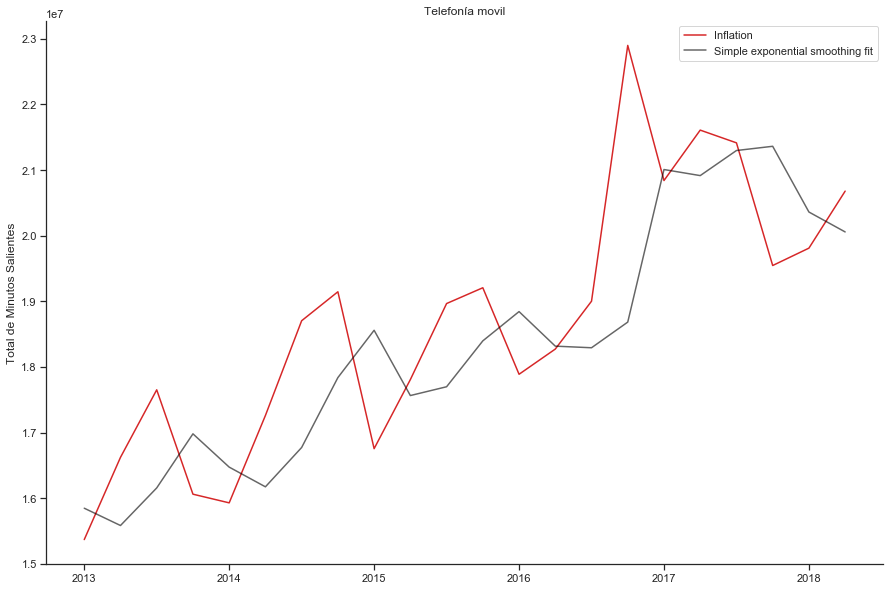

In [18]:
fig, ax= plt.subplots(figsize=(15,10))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.6)
ax.set_xlabel('')
ax.set_ylabel('Total de Minutos Salientes')
ax.set_title('Telefonía movil')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Análisis de Residuo

In [19]:
resid=y-fitted_ses # model_ses.resid isn't a panda.Series, so no index, no plot

In [26]:
fitted_ses

2013Q1    1.584640e+07
2013Q2    1.558266e+07
2013Q3    1.615535e+07
2013Q4    1.697981e+07
2014Q1    1.647269e+07
2014Q2    1.617235e+07
2014Q3    1.677179e+07
2014Q4    1.783688e+07
2015Q1    1.855812e+07
2015Q2    1.756327e+07
2015Q3    1.769732e+07
2015Q4    1.839658e+07
2016Q1    1.884293e+07
2016Q2    1.831621e+07
2016Q3    1.829170e+07
2016Q4    1.868291e+07
2017Q1    2.100790e+07
2017Q2    2.091546e+07
2017Q3    2.129771e+07
2017Q4    2.136219e+07
2018Q1    2.036039e+07
2018Q2    2.005690e+07
Freq: Q-DEC, dtype: float64

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

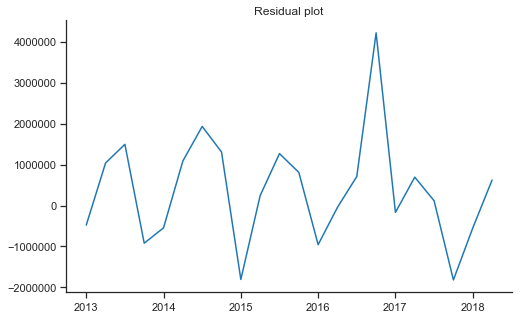

In [20]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Next is the residual ACF plot aka correlogram

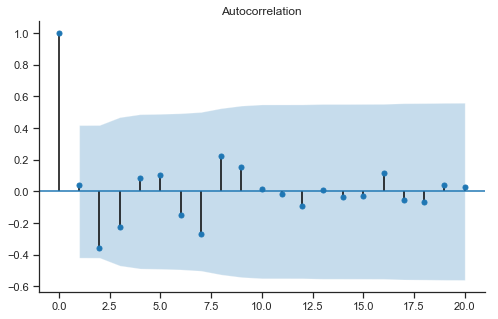

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


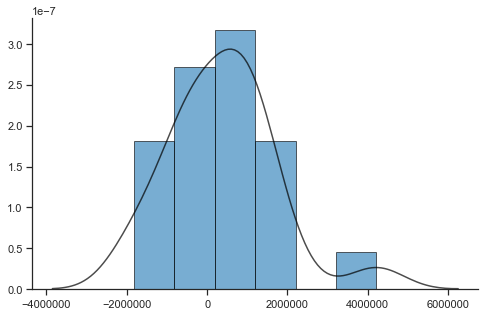

In [22]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.6, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation

In [23]:
# Real time forecasting - use it as a template - expanding window

validation=y['2017Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2017Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
2017Q2,20840252.0,2.089379e+07,21608730.0
2017Q3,21608730.0,2.137993e+07,21414647.0
2017Q4,21414647.0,2.140175e+07,19545262.0
2018Q1,19545262.0,2.030973e+07,19809971.0
2018Q2,19809971.0,1.998468e+07,20678910.0


We find that simple exponential smoothing generates more accurate forecasts. 

In [24]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,1237544.45,528114.428
SES,1220093.60,498660.871


## Forecast

We show how to do expanding and rolling point forecast. 

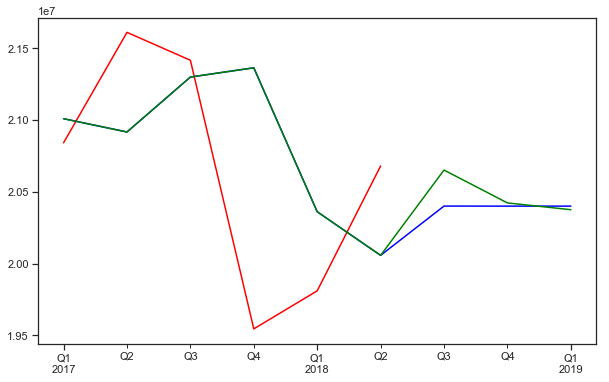

In [25]:
h=3
w=h*2
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(10,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');